In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import ChainMap
from scipy.integrate import cumtrapz, trapz
import re
import importlib
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
# local modules
from fastsim import simdrivehot, simdrive, vehicle, cycle, params, utils
import hot_utilities as hot_utils
importlib.reload(hot_utils)
# importlib.reload(simdrive)
# importlib.reload(cycle)

<module 'hot_utilities' from 'C:\\Users\\cbaker2\\Documents\\GitHub\\fastsim\\docs\\hot_utilities.py'>

# IMPORTANT TASKS
## General
Make sure temp is initalized for each sim_drive_walk  
Make sure fc efficiency impact is accounted for  
Make sure heater affects engine temp and maybe aux load  
Make sure A/C affects aux load  
Cabin thermal model before tuning?

## Tuning
### Parameters
radiator convection coeff.  
idle convection coeff.  
heater something  
thermal mass = f(displacement)?  
diameter = f(displacement)?

### Objectives
fuel consumption  
temperature fit  
eng. temperature derivative fit  
cabin temperature fit  
cabin temperature derivative fit



In [3]:
df = hot_utils.load_test_data(use_cs=True, use_hs=True)
idx = pd.IndexSlice # used to slice multi index 

cyc_name = 'us06x4 0F cs'
# cyc_name = 'us06x2 95F hs'

Loading test data.
Elapsed time to read data files: 3.702e+00 s


In [16]:
t0 = time.time()
test_time_steps = df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values
test_te_amb = df.loc[idx[cyc_name, :, :], 'Cell_Temp[C]'].values

cycSecs = np.arange(0, round(test_time_steps[-1], 0))
cycMps = np.interp(cycSecs, 
    test_time_steps, 
    df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values)

cyc = cycle.Cycle(cyc_dict={'cycSecs':cycSecs, 'cycMps':cycMps})
cyc_jit = cyc.get_numba_cyc()
print("Elapsed time to create cycle: {:.2e} s".format(time.time() - t0))

Elapsed time to create cycle: 6.08e-02 s


In [17]:
t0 = time.time()
veh = vehicle.Vehicle(veh_file=Path('../vehdb/2012 Ford Fusion.csv'))
veh_jit = veh.get_numba_veh()
print(time.time() - t0)

# correcting for actual vehicle coastdown parameters
veh_jit.dragCoef, veh_jit.wheelRrCoef = utils.abc_to_drag_coeffs(3625 / 2.2, 
                                                         veh.frontalAreaM2, 
                                                         35.55, 0.2159, 0.0182)
veh_jit.auxKw = 1.1 # getting difference between test and model to remain constant during idle
veh_jit.fcEffArray *= 1 / 1.0539 # correcting for remaining difference

0.06482720375061035


In [18]:
t0 = time.time()
sim_drive = simdrivehot.SimDriveHotJit(cyc_jit, veh_jit, 
    teAmbDegC = np.interp(cycSecs, test_time_steps, test_te_amb),
      teFcInitDegC=df.loc[idx[cyc_name, :, 0], 'CylinderHeadTempC'][0]) 

params = ['fcThrmMass', 'fcDiam', 'hFcToAmbStop', 'radiator_eff', 'fcTempEffOffset', 'fcTempEffSlope']
x = [1.420e+02, 2.116e+00, 1.824e+02, 1.669e+01, 3.190e-01, 7.285e-03] # really good f
# x = [1.524e+02, 1.716e-01, 3.715e+00, 1.670e+01, 2.813e-01, 8.624e-03] 
# x = [2.426e+02, 4.803e+00, 3.020e+01, 3.130e+01, 4.023e-01, 2.663e-02]


for i, param in enumerate(params):
    sim_drive.__setattr__(param, x[i])
    
# sim_drive.fcTempEffOffset = 0.05
    
sim_drive.sim_drive()
print(f'Elapsed time: {time.time() - t0:.2e} s')

Elapsed time: 2.19e-02 s


### Results

Text(0, 0.5, 'Speed \nAchieved [mps]')

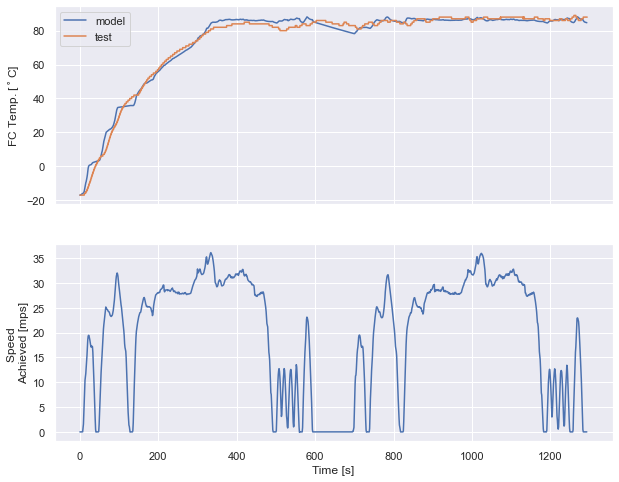

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs, sim_drive.teFcDegC, label='model')
ax1.plot(test_time_steps, df.loc[idx[cyc_name, :, :], 'CylinderHeadTempC'], label='test')
ax1.set_ylabel('FC Temp. [$^\circ$C]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')

Model uses 0.39% more fuel than test.


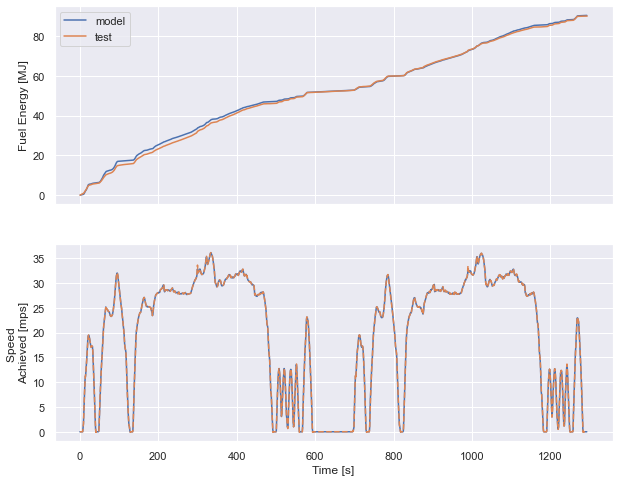

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs[1:], cumtrapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch * 1e-3), label='model')
ax1.plot(test_time_steps[1:], cumtrapz(x=test_time_steps, y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'] * 1e-3), label='test')
ax1.set_ylabel('Fuel Energy [MJ]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch, label='model')
ax2.plot(df.loc[idx[cyc_name, :, :], 'Time[s]'], 
         df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch) - 
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

Model uses 0.39% more fuel than test.


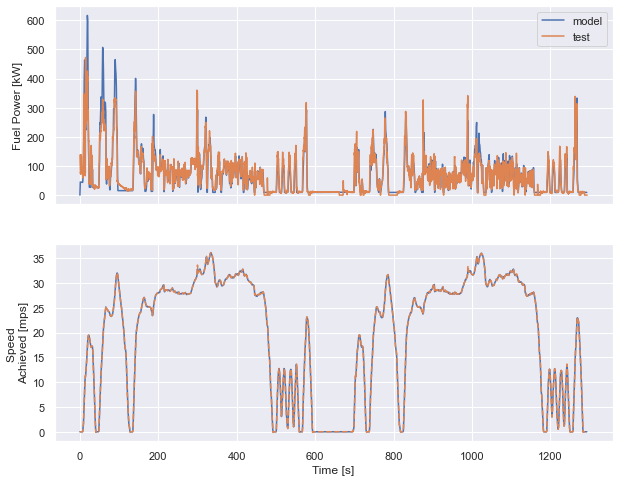

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs, sim_drive.fcKwInAch, label='model')
ax1.plot(test_time_steps, df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'], label='test')
ax1.set_ylabel('Fuel Power [kW]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch, label='model')
ax2.plot(df.loc[idx[cyc_name, :, :], 'Time[s]'], 
         df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch) - 
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

Model uses 0.39% more fuel than test.


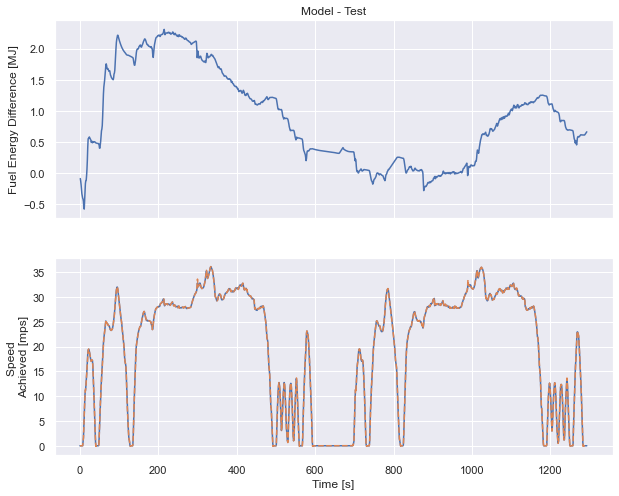

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs[1:], 
         cumtrapz(x=cyc.cycSecs, 
                  y=sim_drive.fcKwInAch - 
                  np.interp(x=cyc.cycSecs, xp=test_time_steps, fp=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
                 ) * 1e-3)

ax1.set_ylabel('Fuel Energy Difference [MJ]')
ax2.plot(cyc.cycSecs, sim_drive.mpsAch, label='model')
ax2.plot(df.loc[idx[cyc_name, :, :], 'Time[s]'], 
         df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')
ax1.set_title('Model - Test')

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch) - 
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

Text(0, 0.5, 'Speed Achieved [mps]')

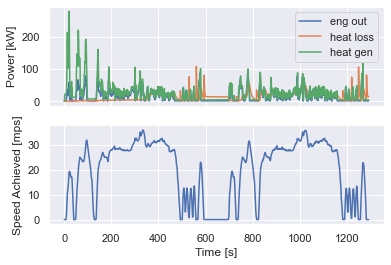

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(cyc.cycSecs, sim_drive.fcKwOutAch, label='eng out')
ax1.plot(cyc.cycSecs, sim_drive.fcConvToAmbKw, label='heat loss')
ax1.plot(cyc.cycSecs, sim_drive.fcHeatGenKw, label='heat gen')
ax1.set_ylabel('Power [kW]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed Achieved [mps]')

Text(0, 0.5, 'Speed Achieved [mps]')

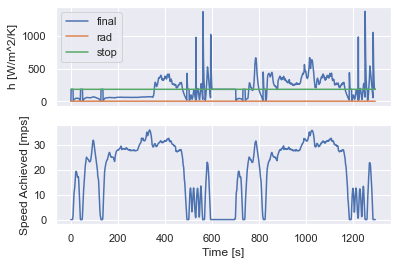

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(cyc.cycSecs, sim_drive.hFcToAmb, label='final')
ax1.plot(cyc.cycSecs, sim_drive.hFcToAmbRad * np.ones(len(cyc.cycSecs)), 
         label='rad')
ax1.plot(cyc.cycSecs, sim_drive.hFcToAmbStop * np.ones(len(cyc.cycSecs)), 
         label='stop')
ax1.set_ylabel('h [W/m^2/K]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed Achieved [mps]')